In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch 
from torch import nn

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


The goal of this notebook is to provide a prelimnary EDA and technique to go about the [Competition](https://www.kaggle.com/competitions/commonlit-evaluate-student-summaries/overview) while also learning some things from other people's work. I have tried to link to other people's work at the end of this notebook. I will be making a competition focused notebook for submission as I can't submit this one (accesses the internet) and I'm unwilling to change any part of the code in this notebook.

## Config

In [2]:
# parameters for training

EPOCHS = 5
model_name = 'bert-base-uncased'
num_labels = 2
learning_rate = 0.01
BATCH_SIZE = 20

# If there are GPUs available, use the first one 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## Loading the data and EDA

In [3]:
summaries = pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/summaries_train.csv')
prompts = pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/prompts_train.csv')

summaries.shape, prompts.shape

((7165, 5), (4, 4))

In [4]:
summaries.head(10)

,student_id,prompt_id,text,content,wording
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757
5,0071d51dab6d,ebad26,They would use chemicals and substances to cha...,0.205683,0.380538
6,0072b649a88c,3b9047,The Egyptian society is really different from ...,0.205683,0.380538
7,00746c7c79c3,ebad26,"Many times the factories would, according to t...",-0.878889,-0.966330
8,00791789cc1f,39c16e,1 element of an ideal tragedy is that it shoul...,-0.210614,-0.471415
9,0086ef22de8f,39c16e,The three elements of an ideal tragedy are: H...,-0.970237,-0.417058


In [5]:
summaries['prompt_id'].nunique()

4

From this we see that we have only 4 `prompt_ids`. Let's look into the prompt_train dataset to see what they're really about

In [6]:
prompts.head()

,prompt_id,prompt_question,prompt_title,prompt_text
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...
1,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
2,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
3,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an..."


Let's investigate about the `prompt_text` to understand more about the given dataset

In [7]:
prompts['prompt_text'].iloc[0]

'Chapter 13 \r\nAs the sequel to what has already been said, we must proceed to consider what the poet should aim at, and what he should avoid, in constructing his plots; and by what means the specific effect of Tragedy will be produced. \r\nA perfect tragedy should, as we have seen, be arranged not on the simple but on the complex plan. It should, moreover, imitate actions which excite pity and fear, this being the distinctive mark of tragic imitation. It follows plainly, in the first place, that the change of fortune presented must not be the spectacle of a virtuous man brought from prosperity to adversity: for this moves neither pity nor fear; it merely shocks us. Nor, again, that of a bad man passing from adversity to prosperity: for nothing can be more alien to the spirit of Tragedy; it possesses no single tragic quality; it neither satisfies the moral sense nor calls forth pity or fear. Nor, again, should the downfall of the utter villain be exhibited. A plot of this kind would, 

In [8]:
prompts['prompt_question'].iloc[0]

'Summarize at least 3 elements of an ideal tragedy, as described by Aristotle.'

In [9]:
texts = summaries[summaries['prompt_id'] == '39c16e'].loc[:,['text', 'content', 'wording']].values.tolist()

for text in texts[:3]:
    print(f"Text: {text[0]}")
    print(f"Content score: {text[1]}")
    print(f"Wording score: {text[2]}")
    print('\n')

Text: 1 element of an ideal tragedy is that it should be arranged on a complex plan.  Another element of an ideal tragedy is that it should only have one main issue. The last element of an ideal tragedy is that it should have a double thread plot and an opposite catastrophe for both good and bad.
Content score: -0.210613934166593
Wording score: -0.471414826967448


Text: The three elements of an ideal tragedy are:  Having a character that isn't bad have misfortune befall them.,  Having no subplots, and ending in death.  
Content score: -0.970236693352702
Wording score: -0.417058297304168


Text: Aristotle states that an ideal tragedy should have a "complex plan" (a well-thought-out plot), "imitate actions which excite pity and fear" (present ideas that might evoke certain emotions from the audience), and should only have a "single... issue", with the "change of fortune" being from "good to bad" (or a character's downfall). 
Content score: -0.387791203829632
Wording score: -0.5841812876

And for the second `prompt_id` in the prompt dataset

In [10]:
prompts['prompt_text'].iloc[1]

'Egyptian society was structured like a pyramid. At the top were the gods, such as Ra, Osiris, and Isis. Egyptians believed that the gods controlled the universe. Therefore, it was important to keep them happy. They could make the Nile overflow, cause famine, or even bring death. \r\nThe Egyptians also elevated some human beings to gods. Their leaders, called pharaohs, were believed to be gods in human form. They had absolute power over their subjects. After pharaohs died, huge stone pyramids were built as their tombs. Pharaohs were buried in chambers within the pyramids. \r\nBecause the people of Egypt believed that their pharaohs were gods, they entrusted their rulers with many responsibilities. Protection was at the top of the list. The pharaoh directed the army in case of a foreign threat or an internal conflict. All laws were enacted at the discretion of the pharaoh. Each farmer paid taxes in the form of grains, which were stored in the pharaoh’s warehouses. This grain was used to

In [11]:
prompts['prompt_question'].iloc[1]

'In complete sentences, summarize the structure of the ancient Egyptian system of government. How were different social classes involved in this government? Cite evidence from the text.'

In [12]:
texts = summaries[summaries['prompt_id'] == '3b9047'].loc[:,['text', 'content', 'wording']].values.tolist()

for text in texts[:3]:
    print(f"Text: {text[0]}")
    print(f"Content score: {text[1]}")
    print(f"Wording score: {text[2]}")
    print('\n')

Text: In Egypt, there were many occupations and social classes involved in day-to-day living. In many instances if you were at the bottom of the social ladder you could climb up, you didn't have to stay a peasant you could work to bring your status up. Everyone worshipped the gods Ra, Osiris, and Isis, but also they would worship their pharaohs like gods as well. Under the pharaohs were the priests, they had the responsibility to entertain or please the said god. The Chain of Command was placed to keep everyone in check, not one person could handle all the civilians and treasures without any aid. Like the tax collector, called a vizier like stated they were in charge of collecting the peoples' tax. They were also one of the rare instances who were able to read and write, that's how they were granted "vizier" Also the soldiers did many things as they would fight in wars or "quelled domestic uprisings". They were in charge of getting the slaves, farmers, and peasants to build palaces or 

We have seen a couple of samples from the dataset. Let's dive into the `content and wording scores` from the train dataset.

In [13]:
summaries[['content', 'wording']].describe()

,content,wording
count,7165.000000,7165.000000
mean,-0.014853,-0.063072
std,1.043569,1.036048
min,-1.729859,-1.962614
25%,-0.799545,-0.872720
50%,-0.093814,-0.081769
75%,0.499660,0.503833
max,3.900326,4.310693


We see that the values for both `content` and `wording` ranges from about -2 to about 5.

Let's take a look at the entry with the lowest content scores as well as its prompt question.

In [14]:
entries = summaries[summaries['content'] == summaries['content'].min()].loc[:, ['prompt_id','text']].values.tolist()

for i in range(len(entries)):
    idx = entries[i][0]
    
    print(f"Prompt question: {(prompts[prompts['prompt_id'] == idx].loc[:, 'prompt_question'].values.tolist())[0]}")
    
    print(f"Summarized Text: {entries[i][1]}")
    
    print('\n')

Prompt question: In complete sentences, summarize the structure of the ancient Egyptian system of government. How were different social classes involved in this government? Cite evidence from the text.
Summarized Text: The structure of egyptans made a ruler called a pharaoh who had black people as slaves like racism pharaohs make its slaves build things such as pryamids and finding gold to melt and the big thing is that they didn't have a map 


Prompt question: Summarize how the Third Wave developed over such a short period of time and why the experiment was ended.
Summarized Text: History Teacher Ron Jones couldn't control his class so he wanted to find a way to keep his students from misbehaving and to start socializing and he created The Third Wave to have his students become more responsible.


Prompt question: Summarize at least 3 elements of an ideal tragedy, as described by Aristotle.
Summarized Text: A tragedy can both be a good and bad thing, it can lead to the downfall of a 

and the entry(s) with the max content score...

In [15]:
entries = summaries[summaries['content'] == summaries['content'].max()].loc[:, ['prompt_id','text']].values.tolist()

for i in range(len(entries)):
    idx = entries[i][0]
    
    print(f"Prompt question: {(prompts[prompts['prompt_id'] == idx].loc[:, 'prompt_question'].values.tolist())[0]}")
    
    print(f"Summarized Text: {entries[i][1]}")
    
    print('\n')

Prompt question: Summarize at least 3 elements of an ideal tragedy, as described by Aristotle.
Summarized Text: As described by Aristotle, three elements of an ideal tragedy would be that the plot should feature the downfall of a man who is not completely evil but who has a flaw which causes his downfall, that it should cause fear and pity in the audience, and that it should have a complex plot, but not a plot with two thread that has two different catastrophes for the good and the bad.  Aristotle  believes that the goal of a tragedy is to "imitate actions which excite pity and fear" and argues that in order for the tragedy to accomplish this goal, it should feature the downfall of a hero "who is neiter eminently good and just, yet whose misfortune is brought on not by vice or depravity, but by some error of judgement or frailty." He thinks that if the hero were purely good, his downfall would simply be shocking to the audience, whereas the downfall of a purely evil man would not arous

As we can see, the entries with the better content score has richer details compared to that with lower content score. As content score is highly correlated with wording score, there's no need to repeat this check on that feature.

Let's merge the summaries with the prompts.

In [16]:
train = summaries.merge(prompts, on = 'prompt_id', how = 'inner')
train.drop(['student_id', 'prompt_id'], axis = 1, inplace = True)

train.head(10)

,text,content,wording,prompt_question,prompt_title,prompt_text
0,The third wave was an experimentto see how peo...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
1,The Third Wave developed rapidly because the ...,3.272894,3.219757,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
2,The third wave only started as an experiment w...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
3,The experimen was orginally about how even whe...,0.567975,0.969062,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
4,The third wave developed so quickly due to the...,-0.910596,-0.081769,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
5,The Thrid Wave movement in the school has more...,1.376083,2.389443,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
6,The Third Wave developed and spead over such a...,0.735204,2.346576,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
7,The thrid wave is a sumbol of strengtht and is...,-1.065590,-0.202142,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
8,the class began to take the Third Wave to seri...,-1.264214,-1.505073,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
9,Jones thought that his project was getting out...,-0.393310,0.627128,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...


## Feature Engineering

In [17]:
train['text_len'] = train['text'].apply(lambda x: len(x.split()))
train['prompt_len'] = train['prompt_text'].apply(lambda x: len(x.split()))
train['length_ratio'] = train['text_len'] / train['prompt_len']

train.head(10)

,text,content,wording,prompt_question,prompt_title,prompt_text,text_len,prompt_len,length_ratio
0,The third wave was an experimentto see how peo...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,61,596,0.102349
1,The Third Wave developed rapidly because the ...,3.272894,3.219757,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,203,596,0.340604
2,The third wave only started as an experiment w...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,60,596,0.100671
3,The experimen was orginally about how even whe...,0.567975,0.969062,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,76,596,0.127517
4,The third wave developed so quickly due to the...,-0.910596,-0.081769,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,27,596,0.045302
5,The Thrid Wave movement in the school has more...,1.376083,2.389443,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,126,596,0.211409
6,The Third Wave developed and spead over such a...,0.735204,2.346576,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,133,596,0.223154
7,The thrid wave is a sumbol of strengtht and is...,-1.065590,-0.202142,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,39,596,0.065436
8,the class began to take the Third Wave to seri...,-1.264214,-1.505073,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,26,596,0.043624
9,Jones thought that his project was getting out...,-0.393310,0.627128,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,44,596,0.073826


/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(5.069444444444445, 0.5, 'Frequency')

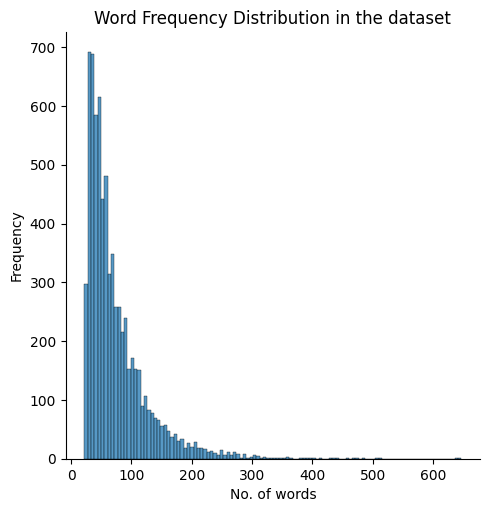

In [18]:
sns.displot(train['text_len'])
plt.title('Word Frequency Distribution in the dataset')
plt.xlabel('No. of words')
plt.ylabel('Frequency')

In [19]:
corr = train[['content', 'wording', 'text_len', 'length_ratio']].corr()

corr

,content,wording,text_len,length_ratio
content,1.000000,0.751380,0.792626,0.770008
wording,0.751380,1.000000,0.536343,0.547368
text_len,0.792626,0.536343,1.000000,0.935513
length_ratio,0.770008,0.547368,0.935513,1.000000


As we see, having a high number of words in the summary is highly correlated to having a good content and wording score. Let's see the `text` from the entry with the least and most amount of words.

In [20]:
entry = train[train['text_len'] == train['text_len'].max()].loc[:, ['text', 'content', 'wording']].values.tolist()

for i in range(len(entry)):
    print(f"Text: {entry[i][0]}")
    print(f"Content score: {entry[i][1]}")
    print(f"Wording score: {entry[i][2]}")
    
    print('\n')

Text: The base starts with farmers and slaves. The economical positions rise as they go up. At the very top point of the pyramid are the gods. Here is the order from greatest to least: Egyptian Gods/Pharaohs,  nobles/priests, soldiers, craftmen/traders, and lastly farmers/slaves. The gods are at the highest position in status. They have the right to overpower everyone. Also, since everyone praises them they believe that the gods were responsible of many things as well. Like safety. Sometimes the pharaohs direct the army or create laws. As stated in the text, "They had absolute power over their subjects...The pharaoh directed the army in case of a foreign threat or an internal conflict. All the laws were enacted at the discretion of the pharaoh." Because the pharaohs/gods couldn't do all the duties themselves they have assistants called viziers which are chief ministers. They have the duty of collecting taxes from people like farmers. According to the article, "No single person could ma

In this case, while the summarized entry gave a lot of details and has a high content score, his wording score was quite poor.

In [21]:
entry = train[train['text_len'] == train['text_len'].min()].loc[:, ['text', 'content', 'wording']].values.tolist()

for i in range(len(entry)):
    print(f"Text: {entry[i][0]}")
    print(f"Content score: {entry[i][1]}")
    print(f"Wording score: {entry[i][2]}")
    
    print('\n')

Text: A tragedy should have a comples plot, imitate actions that bring people to pity or fear, and shoudn't be a run-of-the-mill plot
Content score: -1.54716321678788
Wording score: -1.46124482282529




#### Misspell check

This was taken from this [notebook](https://www.kaggle.com/code/vassylkorzh/feature-engineering/notebook). 

In [22]:
!pip install pyspellchecker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 46.0 MB/s eta 0:00:0000:0100:01


In [23]:
from spellchecker import SpellChecker

In [24]:
import nltk

In [25]:
spellchecker = SpellChecker()

def get_misspelled_count(text):
    tokens = nltk.word_tokenize(text)
    misspelled = [token for token in spellchecker.unknown(tokens) if token.isalpha()]
    
    return len(misspelled)

In [26]:
train['misspelled'] = train['text'].apply(lambda x: get_misspelled_count(x))

In [27]:
train.head(10)

,text,content,wording,prompt_question,prompt_title,prompt_text,text_len,prompt_len,length_ratio,misspelled
0,The third wave was an experimentto see how peo...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,61,596,0.102349,2
1,The Third Wave developed rapidly because the ...,3.272894,3.219757,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,203,596,0.340604,10
2,The third wave only started as an experiment w...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,60,596,0.100671,1
3,The experimen was orginally about how even whe...,0.567975,0.969062,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,76,596,0.127517,4
4,The third wave developed so quickly due to the...,-0.910596,-0.081769,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,27,596,0.045302,2
5,The Thrid Wave movement in the school has more...,1.376083,2.389443,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,126,596,0.211409,5
6,The Third Wave developed and spead over such a...,0.735204,2.346576,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,133,596,0.223154,4
7,The thrid wave is a sumbol of strengtht and is...,-1.065590,-0.202142,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,39,596,0.065436,3
8,the class began to take the Third Wave to seri...,-1.264214,-1.505073,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,26,596,0.043624,2
9,Jones thought that his project was getting out...,-0.393310,0.627128,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,44,596,0.073826,4


In [28]:
corr = train[['text_len', 'length_ratio', 'misspelled', 'content', 'wording']].corr()

corr

,text_len,length_ratio,misspelled,content,wording
text_len,1.000000,0.935513,0.317685,0.792626,0.536343
length_ratio,0.935513,1.000000,0.391961,0.770008,0.547368
misspelled,0.317685,0.391961,1.000000,0.251858,0.165977
content,0.792626,0.770008,0.251858,1.000000,0.751380
wording,0.536343,0.547368,0.165977,0.751380,1.000000


[More Feature Engineering ideas](https://www.kaggle.com/code/vassylkorzh/feature-engineering/notebook)

## Text Preprocessing

In [29]:
from transformers import AutoTokenizer


tokenizer = AutoTokenizer.from_pretrained(model_name)

In [30]:
from torch.utils.data import Dataset

class TextDataset(Dataset):
    def __init__(self, texts, feature_cols, targets, tokenizer, max_length):
        self.texts = texts
        self.feature_cols = feature_cols
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        
        encoding = self.tokenizer.encode_plus(text,
                                             add_special_tokens = True,
                                             max_length = self.max_length,
                                             return_token_type_ids = False,
                                             padding = 'max_length',
                                             truncation = True,
                                             return_attention_mask = True,
                                             return_tensors = 'pt')
        
        item = {'input_ids': encoding['input_ids'].flatten(),
               'attention_mask': encoding['attention_mask'].flatten(),
               'feature_cols': torch.tensor(self.feature_cols[idx], dtype=torch.float), 
               'target': torch.tensor(self.targets[idx], dtype=torch.float)}
        
        return item

In [31]:
train.head()

,text,content,wording,prompt_question,prompt_title,prompt_text,text_len,prompt_len,length_ratio,misspelled
0,The third wave was an experimentto see how peo...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,61,596,0.102349,2
1,The Third Wave developed rapidly because the ...,3.272894,3.219757,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,203,596,0.340604,10
2,The third wave only started as an experiment w...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,60,596,0.100671,1
3,The experimen was orginally about how even whe...,0.567975,0.969062,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,76,596,0.127517,4
4,The third wave developed so quickly due to the...,-0.910596,-0.081769,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,27,596,0.045302,2


In [32]:
feature_cols = ['text_len', 'prompt_len', 'length_ratio', 'misspelled']
targets = ['content', 'wording']
MAX_LENGTH = 512
feature_col_size = len(feature_cols)

dataset = TextDataset(texts = train['text'],
                     feature_cols = train[feature_cols].values,
                     targets = train[targets].values,
                     tokenizer = tokenizer,
                     max_length = MAX_LENGTH)

In [33]:
dataset[1]

{'input_ids': tensor([  101,  1996,  2353,  4400,  2764,  5901,  2138,  1996,  2493,  8991,
         20023,  2135,  3373,  2008,  2009,  2001,  1996,  2190,  2607,  1997,
          2895,  1012,  2037,  7022,  1010,  9353, 25377, 13602,  8163,  1010,
          1998,  2465, 19362,  4588, 11514,  3370,  1013,  5248,  2018,  5301,
         12099,  2144,  1996,  7551,  2211,  1012,  2045,  2106,  2025,  4025,
          2000,  2022,  2151,  9530,  5332,  4226, 12325,  2015,  1999,  1996,
          2493,  2159,  1012,  2027,  2150,  5186,  5117,  1999,  2035,  1996,
          2353,  4400,  2552, 12848,  7616,  2119,  2503,  1998,  2648, 22794,
          9823,  1012,  1996,  7551,  3092,  2138,  1996,  2493,  2020,  2061,
         14314,  2055,  1996,  1000,  2929,  1000,  1012,  1996,  2381,  2465,
          1997,  4228,  5901,  3473,  2000,  3263,  1999,  2093,  2420,  1012,
          2008,  2965, 10894,  2493,  2587,  1037,  2082,  1000,  2929,  1000,
          1999,  2048,  2420,  1012,  2

## Modelling

In [34]:
from transformers import AutoModelForSequenceClassification

In [35]:
class CustomModel(nn.Module):
    def __init__(self, model_name, num_labels, feature_col_size):
        """Instantiate a model that can fit on the dataset"""
        
        super().__init__()
        self.model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = num_labels)
        self.numerics = nn.Linear(feature_col_size, 16)
        self.final_layer = nn.Linear(16 + num_labels, num_labels)
        
    def forward(self, input_ids, attention_mask, feature_cols):
        text_output = self.model(input_ids = input_ids, attention_mask = attention_mask)
        numerics = self.numerics(feature_cols)
        concat_features = torch.cat([text_output.logits, numerics], dim = 1)
        
        final_output = self.final_layer(concat_features)
        
        return final_output

In [36]:
model = CustomModel(model_name, num_labels, feature_col_size)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CustomModel(
  (model): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bi

In [37]:
# loss and optimizer

from torch.optim import Adam
from torch.nn import MSELoss


optimizer = Adam(model.parameters(), lr = learning_rate)
loss_function = MSELoss()

In [38]:
# split the dataset to train and validation dataset

from sklearn.model_selection import train_test_split

train_dataset, val_dataset = train_test_split(dataset, test_size = 0.2, shuffle = True, random_state = 42)

In [39]:
print(len(train_dataset), len(val_dataset))

5732 1433


In [40]:
# load the dataset using pytorch's dataloader tool

from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE)

We have `len(train_dataset)//batch_size` steps in training the dataset. From above, this is about 286 steps

In [41]:
def train_step(train_loader):
    """The training loop for the dataset"""
    
    for step, batch in enumerate(train_loader):
        epochal_loss = 0
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        feature_cols = batch['feature_cols'].to(device)
        targets = batch['target'].to(device)
        
        optimizer.zero_grad()
        
        outputs = model(input_ids, attention_mask, feature_cols)
        loss = loss_function(outputs, targets)
        epochal_loss += loss
        loss.backward()
        
        optimizer.step()
        
        if step % 50 == 0:
            print(f"Epoch {epoch + 1} Step {step} Loss {loss.item()}")
            
    print(f"Epoch {epoch + 1} Train Loss: {epochal_loss/len(train_loader)}")

In [42]:
def val_step(val_loader):
    """The validation loop"""
    
    with torch.no_grad():
        for step, batch in enumerate(val_loader):
            epochal_loss = 0
            
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            feature_cols = batch['feature_cols'].to(device)
            targets = batch['target'].to(device)
            
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask, feature_cols)
            loss = loss_function(outputs, targets)
            epochal_loss += loss
        
        print(f"Epoch {epoch + 1} Validation Loss: {epochal_loss/len(val_loader)}")
        print('\n')

In [43]:
import time

for epoch in range(EPOCHS):
    start = time.time()
    
    train_step(train_loader)
    val_step(val_loader)
    print(f"Total time for training epoch {epoch + 1}: {time.time() - start}s")
    print('\n')

Epoch 1 Step 0 Loss 2501.06689453125
Epoch 1 Step 50 Loss 5.773313045501709
Epoch 1 Step 100 Loss 1.0692678689956665
Epoch 1 Step 150 Loss 1.3866838216781616
Epoch 1 Step 200 Loss 0.43000322580337524
Epoch 1 Step 250 Loss 0.4149165153503418
Epoch 1 Train Loss: 0.002306930487975478
Epoch 1 Validation Loss: 0.011802476830780506


Total time for training epoch 1: 310.2771849632263s


Epoch 2 Step 0 Loss 0.8397906422615051
Epoch 2 Step 50 Loss 0.6197360157966614
Epoch 2 Step 100 Loss 1.0379801988601685
Epoch 2 Step 150 Loss 1.9733127355575562
Epoch 2 Step 200 Loss 0.4646628499031067
Epoch 2 Step 250 Loss 0.5914109945297241
Epoch 2 Train Loss: 0.002757787238806486
Epoch 2 Validation Loss: 0.01019695121794939


Total time for training epoch 2: 308.9632577896118s


Epoch 3 Step 0 Loss 0.7715773582458496
Epoch 3 Step 50 Loss 0.35316184163093567
Epoch 3 Step 100 Loss 1.0064858198165894
Epoch 3 Step 150 Loss 2.0574071407318115
Epoch 3 Step 200 Loss 0.4525570571422577
Epoch 3 Step 250 Loss 1.8010

## Evaluation

In [44]:
test_summaries = pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/summaries_test.csv')
test_prompt = pd.read_csv('/kaggle/input/commonlit-evaluate-student-summaries/prompts_test.csv')


# feature engineering on the test set

test = test_summaries.merge(test_prompt, on = 'prompt_id', how = 'inner')
test.drop(['student_id', 'prompt_id'], axis = 1, inplace = True)

test['text_len'] = test['text'].apply(lambda x: len(x.split()))
test['prompt_len'] = test['prompt_text'].apply(lambda x: len(x.split()))
test['length_ratio'] = test['text_len'] / train['prompt_len']

test['misspelled'] = test['text'].apply(lambda x: get_misspelled_count(x))

In [45]:
class TestTextDataset(Dataset):
    def __init__(self, texts, feature_cols, tokenizer, max_length):
        self.texts = texts
        self.feature_cols = feature_cols
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        
        encoding = self.tokenizer.encode_plus(text,
                                             add_special_tokens = True,
                                             max_length = self.max_length,
                                             return_token_type_ids = False,
                                             padding = 'max_length',
                                             truncation = True,
                                             return_attention_mask = True,
                                             return_tensors = 'pt')
        
        item = {'input_ids': encoding['input_ids'].flatten(),
               'attention_mask': encoding['attention_mask'].flatten(),
               'feature_cols': torch.tensor(self.feature_cols[idx], dtype=torch.float)
               }
        
        return item

In [46]:
test_dataset = TestTextDataset(test['text'],
                              test[feature_cols].values,
                              tokenizer,
                              MAX_LENGTH)
test_loader = DataLoader(test_dataset)

In [47]:
preds = []

for batch in test_loader:
    with torch.no_grad():
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        feature_cols = batch['feature_cols'].to(device)
        
        outputs = model(input_ids, attention_mask, feature_cols)
        preds.extend(outputs.cpu().numpy())

In [48]:
preds

[array([-0.69977164, -0.0328199 ], dtype=float32),
 array([-0.69977164, -0.0328199 ], dtype=float32),
 array([-0.69977164, -0.0328199 ], dtype=float32),
 array([-0.69977164, -0.0328199 ], dtype=float32)]

## Submission

In [49]:
preds[0]

array([-0.69977164, -0.0328199 ], dtype=float32)

In [50]:
submission = pd.DataFrame({
    'student_id': test_summaries['student_id'],
    'content': [pred[0] for pred in preds],
    'wording': [pred[1] for pred in preds]
})

In [51]:
submission

,student_id,content,wording
0,000000ffffff,-0.699772,-0.03282
1,111111eeeeee,-0.699772,-0.03282
2,222222cccccc,-0.699772,-0.03282
3,333333dddddd,-0.699772,-0.03282


In [52]:
submission.to_csv('submission.csv', index = False)

## Resources

1. [Beginner Friendly BERT](https://www.kaggle.com/code/suraj520/beginner-friendly-bert)
2. [Deberta + Additional features](https://www.kaggle.com/code/suraj520/beginner-friendly-bert)